In [1]:
#####Nested Bayesian Tucker Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [3]:
####データの発生####
##データの設定
type_n = 2
graph = 2
k1 = 12
k2 = 10
company = 5000
item = 3000
element = 250
Lambda1 = np.random.gamma(20.0, 1/0.2, company)
Lambda2 = np.random.gamma(25.0, 1/0.2, company)
pt1 = np.random.poisson(Lambda1, company)
pt2 = np.random.poisson(Lambda2, company)
N1 = np.sum(pt1); N2 = np.sum(pt2)
k_vec1 = np.array(np.repeat(1, k1), dtype="float32")
k_vec2 = np.array(np.repeat(1, k2), dtype="float32")

In [4]:
##IDとインデックスを作成
#IDの作成
company_id1 = np.repeat(np.arange(company), pt1)
company_id2 = np.repeat(np.arange(company), pt2)
pt_id1 = np.array(list(itertools.chain(*[np.array(range(pt1[i]), dtype="int") for i in range(company)])))
pt_id2 = np.array(list(itertools.chain(*[np.array(range(pt2[i]), dtype="int") for i in range(company)])))

#インデックスの設定
company_list1 = [i for i in range(company)]
company_list2 = [i for i in range(company)]
for i in range(company):
    company_list1[i] = np.array(np.where(company_id1==i)[0], dtype="int")
    company_list2[i] = np.array(np.where(company_id2==i)[0], dtype="int")

In [5]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [6]:
##itemとelementの割当を生成
#トピック割当を生成
topic = 25
theta_topic = np.random.dirichlet(np.repeat(0.3, topic), company)
phi_item = np.random.dirichlet(np.repeat(0.25, item), topic)
phi_element = np.random.dirichlet(np.repeat(0.25, element), topic)
z1 = np.array(rmnom(theta_topic[company_id1, ], N1, topic, np.arange(N1), 0), dtype="int16")
z21 = np.array(rmnom(theta_topic[company_id2, ], N2, topic, np.arange(N2), 0), dtype="int16")
z22 = np.array(rmnom(theta_topic[company_id2, ], N2, topic, np.arange(N2), 0), dtype="int16")

#多項分布からitemとelementを生成
item_id1 = np.zeros(N1, dtype="int16"); item_id21 = np.zeros(N2, dtype="int16"); item_id22 = np.zeros(N2, dtype="int16")
element_id1 = np.zeros(N1, dtype="int16"); element_id21 = np.zeros(N2, dtype="int16"); element_id22 = np.zeros(N2, dtype="int16")
for i in range(company):
    index1 = company_list1[i]; index2 = company_list2[i]
    item_id1[index1] = np.array(rmnom(phi_item[z1[index1, ], ], pt1[i], item, np.arange(pt1[i]), 0), dtype="int16")
    element_id1[index1] = np.array(rmnom(phi_element[z1[index1, ], ], pt1[i], element, np.arange(pt1[i]), 0), dtype="int16")
    item_id21[index2] = np.array(rmnom(phi_item[z21[index2, ], ], pt2[i], item, np.arange(pt2[i]), 0), dtype="int16")
    item_id22[index2] = np.array(rmnom(phi_item[z22[index2, ], ], pt2[i], item, np.arange(pt2[i]), 0), dtype="int16")
    element_id21[index2] = np.array(rmnom(phi_element[z21[index2, ], ], pt2[i], element, np.arange(pt2[i]), 0), dtype="int16")
    element_id22[index2] = np.array(rmnom(phi_element[z22[index2, ], ], pt2[i], element, np.arange(pt2[i]), 0), dtype="int16")
    
#itemとelementのインデックス
item_list1 = [i for i in range(item)]; item_list21 = [i for i in range(item)]; item_list22 = [i for i in range(item)]
item_n1 = np.repeat(0, item); item_n21 = np.repeat(0, item); item_n22 = np.repeat(0, item)
element_list1 = [i for i in range(element)]; element_list21 = [i for i in range(element)]; element_list22 = [i for i in range(element)]
element_n1 = np.repeat(0, element); element_n21 = np.repeat(0, element); element_n22 = np.repeat(0, element)
for i in range(item):
    item_list1[i] = np.array(np.where(item_id1==i)[0], dtype="int")
    item_list21[i] = np.array(np.where(item_id21==i)[0], dtype="int")
    item_list22[i] = np.array(np.where(item_id22==i)[0], dtype="int")
    item_n1[i] = item_list1[i].shape[0]
    item_n21[i] = item_list21[i].shape[0]
    item_n22[i] = item_list22[i].shape[0]
for i in range(element):
    element_list1[i] = np.array(np.where(element_id1==i)[0], dtype="int")
    element_list21[i] = np.array(np.where(element_id21==i)[0], dtype="int")
    element_list22[i] = np.array(np.where(element_id22==i)[0], dtype="int")
    element_n1[i] = element_list1[i].shape[0]
    element_n21[i] = element_list21[i].shape[0]
    element_n22[i] = element_list22[i].shape[0]

In [7]:
####応答変数を生成####
per_min = 200; per_max = 200
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータを生成
    #階層モデルの事前分布
    alpha1 = np.repeat(0.0, k1)
    alpha2 = np.repeat(0.0, k2)
    Cov_v = np.diag(np.repeat(0.5, k1))
    Cov_i = np.diag(np.repeat(0.4, k2))
    Cov_e = np.diag(np.repeat(0.4, k2))
    Covt_v = Cov_v.copy(); Covt_i = Cov_i.copy(); Covt_e = Cov_e.copy()
    
    #モデルパラメータを生成
    Sigma = np.array([1.0])
    beta = np.array([-0.75, -0.75])
    theta_v = np.random.multivariate_normal(alpha1, Cov_v, company)
    theta_i = np.random.multivariate_normal(alpha2, Cov_i, item)
    theta_e = np.random.multivariate_normal(alpha2, Cov_e, element)
    omega1 = np.random.normal(0, 0.5, k1*k2).reshape(k1, k2)
    omega2 = np.random.normal(0, 0.5, k1*k2*k2).reshape(k1, k2, k2)
    betat = beta.copy()
    thetat_v = theta_v.copy(); thetat_i = theta_i.copy(); thetat_e = theta_e.copy()
    omegat1 = omega1.copy(); omegat2 = omega2.copy()

    #正規分布から応答変数を生成
    #タッカー分解の期待値
    joint_theta1 = theta_i[item_id21, ] * theta_e[element_id21, ]
    joint_theta2 = theta_i[item_id22, ] * theta_e[element_id22, ]
    uv1 = np.dot(np.dot(theta_v, omega1)[company_id1, ] * theta_i[item_id1, ] * theta_e[element_id1, ], k_vec2)
    uv2 = np.zeros((N2, k2))
    for j in range(k2):
        uv2 += np.dot(theta_v, omega2[:, :, j])[company_id2, ]
    uv2 = np.dot(uv2 * joint_theta1 * joint_theta2, k_vec2)
    mu1 = beta[0] + uv1; mu2 = beta[1] + uv2

    #潜在効用から二値変数を生成
    U1 = np.random.normal(mu1, Sigma, N1); UT1 = U1.copy()
    U2 = np.random.normal(mu2, Sigma, N2); UT2 = U2.copy()
    y1 = (U1 >= 0)*1 + (U1 < 0)*0  ; y2 = (U2 >= 0)*1 + (U2 < 0)*0
    Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)
    Prob1[Prob1==1.0] = 0.9999999999; Prob1[Prob1==0] = np.power(10.0, -100)
    Prob2[Prob2==1.0] = 0.9999999999; Prob2[Prob2==0] = np.power(10.0, -100)

    #break条件
    if ((np.mean(y1) > 0.2) & (np.mean(y1) < 0.4) & (np.mean(y2) > 0.2) & (np.mean(y2) < 0.4) &
        (np.sum(U1 <= -7.5) < N1/per_min) & (np.sum(U1 > 7.5) < N1/per_max) & 
        (np.sum(U2 <= -7.5) < N2/per_min) & (np.sum(U2 > 7.5) < N2/per_max)):
            break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


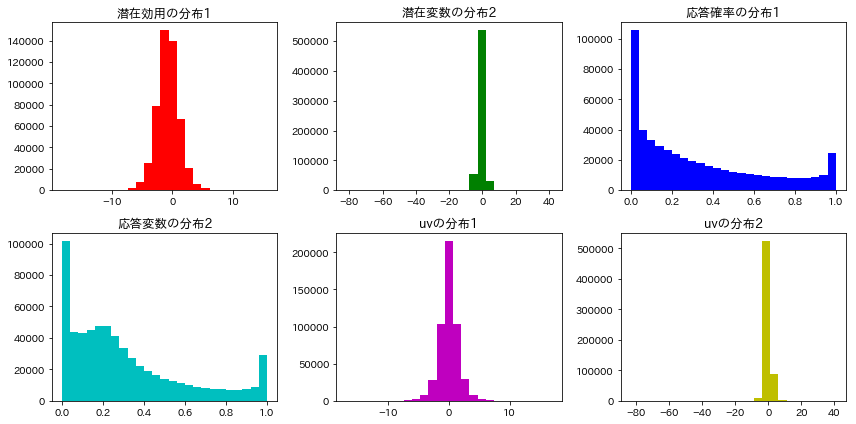

In [8]:
#潜在変数ごとのヒストグラム
dt = [U1, U2, Prob1, Prob2, uv1, uv2]
fig_range = np.append(np.array([np.min(U1), np.min(U2), 0, 0, np.min(uv1), np.min(uv2)]), 
                      np.array([np.max(U1), np.max(U2), 1.0, 1.0, np.max(uv1), np.max(uv2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布1", "潜在変数の分布2", "応答確率の分布1", "応答変数の分布2", "uvの分布1", "uvの分布2"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [9]:
####テストデータを生成####
##データの設定
division = 2
pt01 = np.random.poisson(Lambda1 / division, company)
pt02 = np.random.poisson(Lambda2 / division, company)
pt01[pt01 < 5] = 5; pt02[pt02 < 5] = 5
N01 = np.sum(pt01)
N02 = np.sum(pt02)

In [10]:
##IDとインデックスを作成
#IDの作成
company_id01 = np.repeat(np.arange(company), pt01)
company_id02 = np.repeat(np.arange(company), pt02)
pt_id01 = np.array(list(itertools.chain(*[np.array(range(pt01[i]), dtype="int") for i in range(company)])))
pt_id02 = np.array(list(itertools.chain(*[np.array(range(pt02[i]), dtype="int") for i in range(company)])))

#インデックスの設定
company_list01 = [i for i in range(company)]
company_list02 = [i for i in range(company)]
for i in range(company):
    company_list01[i] = np.array(np.where(company_id01==i)[0], dtype="int")
    company_list02[i] = np.array(np.where(company_id02==i)[0], dtype="int")

In [11]:
##itemとelementの割当を生成
#トピック割当を生成
z1 = np.array(rmnom(theta_topic[company_id01, ], N01, topic, np.arange(N01), 0), dtype="int16")
z21 = np.array(rmnom(theta_topic[company_id02, ], N02, topic, np.arange(N02), 0), dtype="int16")
z22 = np.array(rmnom(theta_topic[company_id02, ], N02, topic, np.arange(N02), 0), dtype="int16")

#多項分布からitemとelementを生成
item_id01 = np.zeros(N01, dtype="int16"); item_id021 = np.zeros(N02, dtype="int16"); item_id022 = np.zeros(N02, dtype="int16")
element_id01 = np.zeros(N01, dtype="int16"); element_id021 = np.zeros(N02, dtype="int16"); element_id022 = np.zeros(N02, dtype="int16")
for i in range(company):
    index1 = company_list01[i]; index2 = company_list02[i]
    item_id01[index1] = np.array(rmnom(phi_item[z1[index1, ], ], pt01[i], item, np.arange(pt01[i]), 0), dtype="int16")
    element_id01[index1] = np.array(rmnom(phi_element[z1[index1, ], ], pt01[i], element, np.arange(pt01[i]), 0), dtype="int16")
    item_id021[index2] = np.array(rmnom(phi_item[z21[index2, ], ], pt02[i], item, np.arange(pt02[i]), 0), dtype="int16")
    item_id022[index2] = np.array(rmnom(phi_item[z22[index2, ], ], pt02[i], item, np.arange(pt02[i]), 0), dtype="int16")
    element_id021[index2] = np.array(rmnom(phi_element[z21[index2, ], ], pt02[i], element, np.arange(pt02[i]), 0), dtype="int16")
    element_id022[index2] = np.array(rmnom(phi_element[z22[index2, ], ], pt02[i], element, np.arange(pt02[i]), 0), dtype="int16")
    
#itemとelementのインデックス
item_list01 = [i for i in range(item)]; item_list021 = [i for i in range(item)]; item_list022 = [i for i in range(item)]
item_n01 = np.repeat(0, item); item_n021 = np.repeat(0, item); item_n022 = np.repeat(0, item)
element_list01 = [i for i in range(element)]; element_list021 = [i for i in range(element)]; element_list022 = [i for i in range(element)]
element_n01 = np.repeat(0, element); element_n021 = np.repeat(0, element); element_n022 = np.repeat(0, element)
for i in range(item):
    item_list01[i] = np.array(np.where(item_id01==i)[0], dtype="int")
    item_list021[i] = np.array(np.where(item_id021==i)[0], dtype="int")
    item_list022[i] = np.array(np.where(item_id022==i)[0], dtype="int")
    item_n01[i] = item_list01[i].shape[0]
    item_n021[i] = item_list021[i].shape[0]
    item_n022[i] = item_list022[i].shape[0]
for i in range(element):
    element_list01[i] = np.array(np.where(element_id01==i)[0], dtype="int")
    element_list021[i] = np.array(np.where(element_id021==i)[0], dtype="int")
    element_list022[i] = np.array(np.where(element_id022==i)[0], dtype="int")
    element_n01[i] = element_list01[i].shape[0]
    element_n021[i] = element_list021[i].shape[0]
    element_n022[i] = element_list022[i].shape[0]

In [12]:
##応答変数を生成
#タッカー分解の期待値
joint_theta1 = theta_i[item_id021, ] * theta_e[element_id021, ]
joint_theta2 = theta_i[item_id022, ] * theta_e[element_id022, ]
uv1 = np.dot(np.dot(theta_v, omega1)[company_id01, ] * theta_i[item_id01, ] * theta_e[element_id01, ], k_vec2)
uv2 = np.zeros((N02, k2))
for j in range(k2):
    uv2 += np.dot(theta_v, omega2[:, :, j])[company_id02, ]
uv2 = np.dot(uv2 * joint_theta1 * joint_theta2, k_vec2)
mu1 = beta[0] + uv1; mu2 = beta[1] + uv2

#潜在効用から二値変数を生成
U01 = np.random.normal(mu1, Sigma, N01); UT01 = U01.copy()
U02 = np.random.normal(mu2, Sigma, N02); UT02 = U02.copy()
y01 = (U01 >= 0)*1 + (U01 < 0)*0  ; y2 = (U02 >= 0)*1 + (U02 < 0)*0

In [13]:
####Nested Bayesian Tucker Decompositionを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [15]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10

In [16]:
##事前分布の設定
#階層モデルの事前分布
alpha1 = np.repeat(0.0, k1)
alpha2 = np.repeat(0.0, k2)
V1 = 0.1 * np.diag(np.ones(k1))
V2 = 0.1 * np.diag(np.ones(k2))
nu = 1
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [ ]:
##itemとelementのインデックスを作成
#インデックスの格納用配列
item_list21 = [i for i in range(item)]
item_list22 = [i for i in range(item)]
item_list23 = [i for i in range(item)]
element_list21 = [i for i in range(element)]
element_list22 = [i for i in range(element)]
element_list23 = [i for i in range(element)]

#インデックスを作成
for i in range(item):
    flag = item_id21==item_id22
    item_list21[i] = np.array(np.where((flag==False) & (item_id21==i))[0], dtype="int")
    item_list22[i] = np.array(np.where((flag==False) & (item_id22==i))[0], dtype="int")
    item_list23[i] = np.where((flag==True) & (item_id21==i))[0]
for i in range(element):
    flag = element_id21==element_id22
    element_list21[i] = np.array(np.where((flag==False) & (element_id21==i))[0], dtype="int")
    element_list22[i] = np.array(np.where((flag==False) & (element_id22==i))[0], dtype="int")
    element_list23[i] = np.where((flag==True) & (element_id21==i))[0]

In [17]:
##パラメータの真値
#階層モデルの分散の真値
Cov_v = np.array(Covt_v.copy(), dtype="float32")
Cov_i = np.array(Covt_i.copy(), dtype="float32")
Cov_e = np.array(Covt_e.copy(), dtype="float32")

#モデルパラメータの真値
Sigma = np.array([1.0], dtype="float32")
beta = np.array(betat, dtype="float32")
theta_v = np.array(thetat_v, dtype="float32")
theta_i = np.array(thetat_i, dtype="float32")
theta_e = np.array(thetat_e, dtype="float32")
omega1 = np.array(omegat1, dtype="float32")
omega2 = np.array(omegat2, dtype="float32")

#タッカー分解の期待値
joint_theta1 = theta_i[item_id21, ] * theta_e[element_id21, ]
joint_theta2 = theta_i[item_id22, ] * theta_e[element_id22, ]
uv1 = np.dot(np.dot(theta_v, omega1)[company_id1, ] * theta_i[item_id1, ] * theta_e[element_id1, ], k_vec2)
uv2 = np.zeros((N2, k2))
for j in range(k2):
    uv2 += np.dot(theta_v, omega2[:, :, j])[company_id2, ]
uv2 = np.dot(uv2 * joint_theta1 * joint_theta2, k_vec2)
mu1 = beta[0] + uv1; mu2 = beta[1] + uv2

In [51]:
##データの設定
#切断領域を定義
rho = 10.0
a1 = np.array((1-y1)*(-rho) + y1*0, dtype="float32")
b1 = np.array(y1*rho + (1-y1)*0, dtype="float32")
a2 = np.array((1-y2)*(-rho) + y2*0, dtype="float32")
b2 = np.array(y2*rho + (1-y2)*0, dtype="float32")

#特徴行列の割当インデックス
allocation_u = np.repeat(np.arange(k1), k2)
allocation_v = np.tile(np.arange(k2), k1)
allocation_omega = np.array([np.delete(np.arange(k2), j).tolist() for j in range(k2)])

array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8]])

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [41]:
index3

array([ 52340, 166564, 249787, 252310, 280759, 330934, 354436, 367772],
      dtype=int64)